## Tiny RPG: a tutorial for Reparameterized Policy Learning

paper: Reparameterized Policy Learning for Multimodal Trajectory Optimization

authors: Zhiao Huang, Litian Liang, Zhan Ling, Xuanlin Li, Chuang Gan, Hao Su

website: https://haosulab.github.io/RPG/

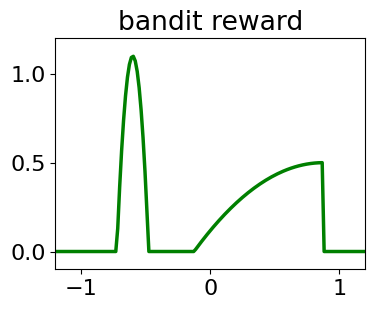

In [1]:
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.rc('font', size=16)
matplotlib.rc('lines', linewidth=2.5)
import matplotlib.pyplot as plt
device = torch.device('cpu')

# feel free to try different reward functions
def reward(x):
    y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
    y2 = torch.clip(-0.125 * (2 * x - 1.75) ** 2 + 0.5, min=0)
    y2 = y2 * (x < 1.75 / 2).float()
    return y1 + y2

# def reward(x):
#     y1 = torch.clip(-18 * (2 * x + 1.2) ** 2 + 1.1, min=0)
#     y2 = torch.clip(-0.125 * (4 * x - 1.75) ** 2 + 0.5, min=0)
#     # y2 = y2 * (x < 1.75 / 4).float()
#     return y1 + y2

def plot_reward(x, y):
    plt.xlim(-1.2, 1.2); plt.ylim(-0.1, 1.2)
    plt.plot(x.reshape(-1).cpu().numpy(), y.reshape(-1).cpu().numpy(), color='green')

# visualize reward landscape
plt.figure(figsize=(4, 3))
plt.title("bandit reward")
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
plt.show()

#### Consider a reward function for a bandit environment below.

This reward function is special in these ways:
1. The area of the left mode is smaller than the area of the right mode.
2. The area of the right mode is clearly a local maximum. A bad RL algorithm can easily stuck there.

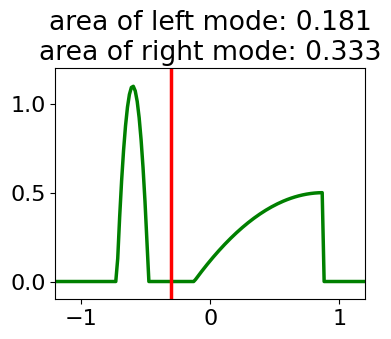

In [2]:
def approx_area(x, y):
    """ numerically estimate the area under the curve defined by x and y """
    return ((x[1:] - x[:-1]) * (y[1:] + y[:-1]) / 2).sum()

x = torch.linspace(-1.5, 1.5, 1000)
y = reward(x)

splitting_point = -0.3

plt.figure(figsize=(4, 3))
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
plt.plot([splitting_point, splitting_point], [-1, 2], color='red')
plt.title(
    f"area of left mode: {approx_area(x[x < splitting_point], y[x < splitting_point]).item():.3f}\n"
    + f"area of right mode: {approx_area(x[x > splitting_point], y[x > splitting_point]).item():.3f}")
plt.show()

#### make a gaussian policy

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as thdist
import torch.nn.functional as thfunc

class Std(nn.Module):
    
    def __init__(
            self, out_dim, mode="local", learn=True, 
            scale=1, log_std_min=-20, log_std_max=2, init_log_std=0
        ):
        super().__init__()
        self.out_dim      = out_dim
        self.mode         = mode
        self.learn        = learn
        self.log_std_min  = log_std_min
        self.log_std_max  = log_std_max
        self.init_log_std = init_log_std
        self.scale        = scale
        assert self.mode in ["global", "local"], "mode must be 'global' or 'local'"
        
        # decide whether to manage std
        self.manage_std   = (mode == "global")
        if not self.learn:
            # if not learning std, then it's global
            self.manage_std = True
        
        # manage std
        self.log_std = None
        if self.manage_std:
            self.log_std = nn.Parameter(
                self.init_log_std * \
                torch.ones((1, out_dim), dtype=torch.float32)
            )
            self.in_dim = 0
        else:
            self.in_dim = out_dim

    def extra_repr(self):
        repr_str = (
            f"mode={self.mode},\n"
            f"learn={self.learn},\n"
            f"log_std_min={self.log_std_min},\n"
            f"log_std_max={self.log_std_max},\n"
            f"init_log_std={self.init_log_std},\n"
            f"scale={self.scale}")
        if self.manage_std:
            repr_str += f",\nlog_std={self.log_std.tolist()}"
        return repr_str

    def forward(self, x):
        if self.manage_std:
            # use the global logstd
            assert self.log_std is not None
            logstd = self.log_std
        else:
            # take the input as logstd
            assert x.shape[-1] == self.out_dim
            logstd = x + self.init_log_std
        
        logstd = torch.clamp(logstd, min=self.log_std_min, max=self.log_std_max)
        
        std = torch.exp(logstd)
        if not self.learn:
            # detach std if not learning it
            std = std.detach()
        
        return std * self.scale
    
class TanhNormalHead(nn.Module):

    def __init__(self, out_dim, std_cfg=dict()):
        super().__init__()
        self.std = Std(out_dim, **std_cfg)
        self.out_dim = out_dim
        self.in_dim = self.out_dim + self.std.in_dim
    
    def forward(self, x):
        assert x.shape[-1] == self.in_dim
        mu = x[..., :self.out_dim]
        std = self.std(x[..., self.out_dim:])
        # sample and log_prob
        dist = thdist.Normal(loc=mu, scale=std)
        u = dist.rsample()
        a = torch.tanh(u)
        log_prob_a = dist.log_prob(u) - (2 * (np.log(2) - u - thfunc.softplus(-2 * u)))
        return dict(dist=dist, a=a, log_prob_a=log_prob_a)

class GaussianPolicy(nn.Module):
    def __init__(self, std_cfg=dict()):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor([0.0]))
        self.std = nn.Parameter(torch.tensor([1.0]))
        self.head = TanhNormalHead(1, std_cfg)

    def forward(self, sample_size):
        x = torch.cat([self.mu, self.std])[None, :].repeat(sample_size, 1)
        return self.head(x)
    
pi_a_example = GaussianPolicy().to(device)
pi_a_example(5)

{'dist': Normal(loc: torch.Size([5, 1]), scale: torch.Size([5, 1])),
 'a': tensor([[-0.8764],
         [ 0.1389],
         [ 0.9901],
         [ 0.9999],
         [ 0.9998]], grad_fn=<TanhBackward0>),
 'log_prob_a': tensor([[-0.5827],
         [-1.9008],
         [ 1.5305],
         [ 5.1990],
         [ 4.6450]], grad_fn=<SubBackward0>)}

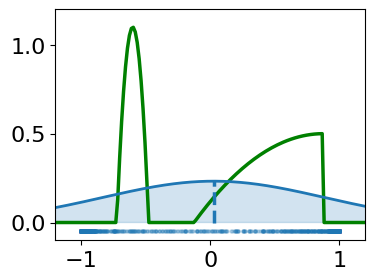

In [4]:
import numpy as np
import torch.nn.functional as thfunc
from scipy.interpolate import make_interp_spline

# visualize the distribution of actions
def dist_hist(actions, bins):
    x_freq = np.linspace(-2.5, 2.5, bins + 1)
    inds = np.digitize(actions, x_freq)
    freq = np.zeros_like(x_freq)
    unique, counts = np.unique(inds, return_counts=True)
    for i, count in zip(unique, counts):
        freq[i-1] = count
    freq = freq / freq.sum() * 2
    return x_freq + (x_freq[1] - x_freq[0]) / 2, freq * 2.4

@torch.no_grad()
def visualize_gaussian_policy(policy, batch_size=10000):
    policy_out = policy(batch_size)
    a = policy_out["a"]
    # when policy is gaussian, fit a gaussian to the distribution for better visualization
    mu, std = a.mean().cpu(), a.std().cpu()
    x = torch.linspace(-1.5, 1.5, 1000)
    # scale the pdf for better visualization
    pdf = torch.exp(-((x - mu) ** 2) / (2 * std ** 2)) / (std * np.sqrt(2 * np.pi))
    # pdf = pdf - (2 * (np.log(2) - x - thfunc.softplus(-2 * x)))  # the tanh transformed pdf
    # pdf[np.abs(x) > 1] = 0
    pdf = pdf / 2  # scale the pdf for better visualization
    plt.plot([mu, mu], [0, pdf.max()], color='C0', linestyle='--')  # plot mean
    plt.plot(x, pdf, color='C0', linewidth=2)
    # scatter action samples
    actions = a.cpu().numpy()
    plt.scatter(actions, np.zeros_like(actions) - 0.05, color='C0', s=5, alpha=0.2)
    plt.fill_between(x, pdf, color='C0', alpha=0.2)

plt.figure(figsize=(4, 3))
# visualize reward landscape
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
# visualize the initialized policy
visualize_gaussian_policy(GaussianPolicy(), batch_size=1000)
plt.show()

#### we can estimate the gradient in 2 different ways for a gaussian policy, reinforce and path-wise gradient.

Reinforce is the gradient estimator that method like PPO use, it estimate gradient from reward samples from a function that we can not evaluate analytical gradient.

$$\nabla_\mu \text{E}_{a\sim\pi(\cdot)}[\log\pi(a) R(a)]$$

Path-wise gradient is the gradient estimator that method like DDPG, SAC use, the gradient is estimated from a function that we can evaluate analytical gradient. Typically Q for model free RL, and reward + dynamics + value function for model based RL.

$$\nabla_\mu \text{E}_{\epsilon\sim\mathcal{N}}[R(\mu + \epsilon\sigma)]$$

In [5]:
batch_size = 1000
sampled_reinforce_grads = []
sampled_pathwise_grads = []

# sample 1000 times
for _ in range(1000):

    # reset policy
    policy = GaussianPolicy()

    # reinforce gradient
    policy.zero_grad()
    policy_out = policy(batch_size)
    policy.mu.retain_grad()
    a, log_prob = policy_out["a"], policy_out["log_prob_a"]
    reward_no_grad = reward(a).detach()
    advantage = reward_no_grad - reward_no_grad.mean()
    (log_prob * reward_no_grad).mean().backward()
    sampled_reinforce_grads.append(policy.mu.grad.item())

    # path-wise gradient
    policy.zero_grad()
    policy_out = policy(batch_size)
    policy.mu.retain_grad()
    a, log_prob = policy_out["a"], policy_out["log_prob_a"]
    reward(a).mean().backward()
    sampled_pathwise_grads.append(policy.mu.grad.item())

print(f"est. reinforce gradient: {np.mean(sampled_reinforce_grads):.3f}")
print(f"est. path-wise gradient: {np.mean(sampled_pathwise_grads):.3f}")

est. reinforce gradient: 0.043
est. path-wise gradient: 0.071


We can see the both gradient estimator gives positive gradient for gaussian mean. This is because under current standard deviaton, the reward actually looks like: (TODO) plot reward under gaussian filter

#### make a reparameterized policy

In [6]:
import torch
import torch.distributions as thdist
import torch.nn.functional as thfunc

class Categorical(thdist.Categorical):

    """ random variable is one-hot encoded """

    def log_prob(self, value):
        value = value.argmax(-1)
        return super().log_prob(value).unsqueeze(-1)
    
    def sample(self, sample_shape=torch.Size()):
        n_classes = self.logits.shape[-1]
        classes = super().sample(sample_shape)
        return thfunc.one_hot(classes, n_classes).float()

class RPGLatentPolicy(nn.Module):
    
    def __init__(self, z_dim) -> None:
        super().__init__()
        self.logits = nn.Parameter(torch.randn(z_dim) / np.sqrt(z_dim))

    def forward(self, sample_size):
        logits = self.logits[None, :].repeat(sample_size, 1)
        dist = Categorical(logits=logits)
        z = dist.sample()
        return dict(dist=dist, z=z, log_prob_z=dist.log_prob(z))

pi_z = RPGLatentPolicy(z_dim=5).to(device)
pi_z_out = pi_z(5)
pi_z_out

{'dist': Categorical(probs: torch.Size([5, 5]), logits: torch.Size([5, 5])),
 'z': tensor([[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]),
 'log_prob_z': tensor([[-1.6993],
         [-0.9261],
         [-0.9261],
         [-1.5376],
         [-1.5376]], grad_fn=<UnsqueezeBackward0>)}

In [7]:
class RPGActionPolicy(nn.Module):

    def __init__(self, z_dim, std_cfg=dict()) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 64), 
            nn.ELU(),
            nn.Linear(64, 2) # mu and std
        )
        self.head = TanhNormalHead(out_dim=1, std_cfg=std_cfg)
    
    def forward(self, z):
        mu_std = self.net(z)
        return self.head(mu_std)

pi_a = RPGActionPolicy(z_dim=5).to(device)
pi_a_out = pi_a(z=pi_z_out["z"])
pi_a_out

{'dist': Normal(loc: torch.Size([5, 1]), scale: torch.Size([5, 1])),
 'a': tensor([[-0.8006],
         [-0.8854],
         [ 0.9344],
         [ 0.9118],
         [-0.8712]], grad_fn=<TanhBackward0>),
 'log_prob_a': tensor([[-0.5311],
         [-0.2785],
         [-0.1278],
         [-0.0365],
         [-0.4841]], grad_fn=<SubBackward0>)}

In [8]:
class RPGPolicy(nn.Module):
    
    def __init__(self, pi_z, pi_a):
        super().__init__()
        self.pi_z = pi_z
        self.pi_a = pi_a

    def forward(self, sample_size):
        pi_z_out = self.pi_z(sample_size)
        pi_a_out = self.pi_a(z=pi_z_out["z"])
        return dict(
            z=pi_z_out["z"],
            log_prob_z=pi_z_out["log_prob_z"],
            a=pi_a_out["a"],
            log_prob_a=pi_a_out["log_prob_a"],
            pi_z=pi_z_out["dist"],
            pi_a=pi_a_out["dist"]
        )

rpg_policy = RPGPolicy(pi_z, pi_a).to(device)
rpg_policy_out = rpg_policy(sample_size=5)
rpg_policy_out

{'z': tensor([[0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]),
 'log_prob_z': tensor([[-1.5376],
         [-1.5376],
         [-0.9261],
         [-0.9261],
         [-0.9261]], grad_fn=<UnsqueezeBackward0>),
 'a': tensor([[ 0.7867],
         [-0.7200],
         [ 0.7967],
         [-0.3178],
         [ 0.3918]], grad_fn=<TanhBackward0>),
 'log_prob_a': tensor([[-0.4055],
         [-0.7373],
         [-0.5038],
         [-0.9603],
         [-0.9295]], grad_fn=<SubBackward0>),
 'pi_z': Categorical(probs: torch.Size([5, 5]), logits: torch.Size([5, 5])),
 'pi_a': Normal(loc: torch.Size([5, 1]), scale: torch.Size([5, 1]))}

In [9]:
class Info(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ELU(),
            nn.Linear(64, z_dim),
        )
    def forward(self, a):
        dist = Categorical(logits=self.net(a))
        return dist

infonet = Info(z_dim=5).to(device)
z, a = rpg_policy_out["z"], rpg_policy_out["a"]
info = infonet(a).log_prob(z)
info

tensor([[-1.5166],
        [-1.3823],
        [-1.2488],
        [-1.3378],
        [-1.2785]], grad_fn=<UnsqueezeBackward0>)

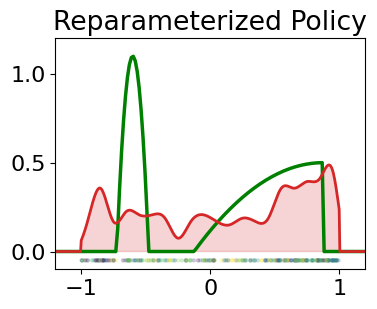

In [10]:
@torch.no_grad()
def visualize_rpg_policy(policy, batch_size=10000, pdf_scale=1):
    policy_out = policy(batch_size)
    a = policy_out["a"]
    # scatter action samples
    z = policy_out["z"].argmax(dim=-1).cpu().numpy()
    actions = a.reshape(-1).cpu().numpy()
    plt.scatter(actions, np.zeros_like(actions) - 0.05, s=5, c=z, alpha=0.2)
    # plt.colorbar()
    plt.clim(z.min(), z.max())
    x_freq, freq = dist_hist(actions, bins=50)
    X_Y_Spline = make_interp_spline(x_freq, freq)
    X_ = np.linspace(x_freq.min(), x_freq.max(), 1000)
    Y_ = np.clip(X_Y_Spline(X_), a_min=0, a_max=None)
    # spline interpolates out of the action bound, it looks confusing
    Y_[np.abs(X_) > 1] = 0
    Y_ *= pdf_scale
    plt.plot(X_, Y_, color='C3', linewidth=2)
    plt.fill_between(X_, Y_, color='C3', alpha=0.2)

plt.figure(figsize=(4, 3))
plt.title("Reparameterized Policy")
x = torch.linspace(-1.5, 1.5, 200)
y = reward(x)
plot_reward(x, y)
# initialize a reparameterized policy, and visualize its action distribution
pi_z = RPGLatentPolicy(z_dim=8)
pi_a = RPGActionPolicy(z_dim=8)
infonet = Info(z_dim=8).to(device)
rpg_policy = RPGPolicy(pi_z, pi_a).to(device)
visualize_rpg_policy(rpg_policy, batch_size=256)
plt.show()

In [14]:
def update_rpg(reward, rpg_policy, policy_opt, info_opt, reward_weight, info_weight, ent_z, ent_a, batch_size):
    policy_opt.zero_grad(); info_opt.zero_grad()
    rpg_out = rpg_policy(sample_size=batch_size)
    z, log_prob_z = rpg_out["z"], rpg_out["log_prob_z"]
    a, log_prob_a = rpg_out["a"], rpg_out["log_prob_a"]
    r = reward(a)
    # optimize pi_z with reinforce
    r_z = reward_weight * r - ent_z * log_prob_z
    adv = (r_z - r_z.mean()).detach()
    # optimize pi_a with path-wise gradient
    info = infonet(a).log_prob(z.detach())  # cross entropy
    r_a = reward_weight * r + info_weight * info - ent_a * log_prob_a
    # RPG policy loss
    loss = -((log_prob_z * adv).mean() + r_a.mean())
    loss.backward()
    policy_opt.step()
    # optimize infonet with cross entropy
    info_log_prob = infonet(a.detach()).log_prob(z.detach()).mean()
    (-info_log_prob).backward()
    info_opt.step()

    elbo = (
        reward_weight * r 
        + info_weight * infonet(a).log_prob(z) 
        - ent_z * log_prob_z 
        - ent_a * log_prob_a).detach().mean().item() 
    return dict(reward=r.mean().item(), elbo=elbo, z=z, a=a, log_prob_z=log_prob_z, log_prob_a=log_prob_a)

In [15]:
def update_gaussian_reinforce(reward, policy, optimizer, reward_weight, ent_a, batch_size):
    optimizer.zero_grad()
    policy_out = policy(sample_size=batch_size)
    a, log_prob_a = policy_out["a"], policy_out["log_prob_a"]
    r = reward(a)
    r_max_ent = reward_weight * reward(a) - ent_a * log_prob_a
    adv = (r_max_ent - r_max_ent.mean()).detach()
    policy_loss = -(log_prob_a * adv).mean()
    policy_loss.backward()
    optimizer.step()

    return dict(reward=r.mean().item())

In [13]:
# plot util functions
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def barplot_color(x, y):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(x)))
    plt.bar(x, y, color=colors)
    plt.xticks(x, labels=x)

def plt_save_fig_array(close=True, clear=True):
    fig = plt.gcf()
    fig.canvas.draw()
    res = np.array(fig.canvas.renderer.buffer_rgba())
    if close: plt.close()
    if clear: plt.clf()
    return res

def animate(clip, filename='animation.mp4', _return=True, fps=10, embed=False):
    # embed = True for Pycharm, otherwise False
    if isinstance(clip, dict):
        clip = clip['image']
    print(f'animating {filename}')
    if filename.endswith('.gif'):
        import imageio
        import matplotlib.image as mpimg
        imageio.mimsave(filename, clip)
        if _return:
            from IPython.display import display
            import ipywidgets as widgets
            return display(widgets.HTML(f'<img src="{filename}" width="750" align="center">'))
        else:
            return

    from moviepy.editor import ImageSequenceClip
    clip = ImageSequenceClip(clip, fps=fps)
    ftype = filename[-3:]
    if ftype == "mp4":
        clip.write_videofile(filename, fps=fps)
    elif ftype == "gif":
        clip.write_gif(filename, fps=fps)
    else:
        raise NotImplementedError(f"file type {ftype} not supported!")

    if _return:
        from IPython.display import Video
        return Video(filename, embed=embed, html_attributes="controls autoplay muted loop")

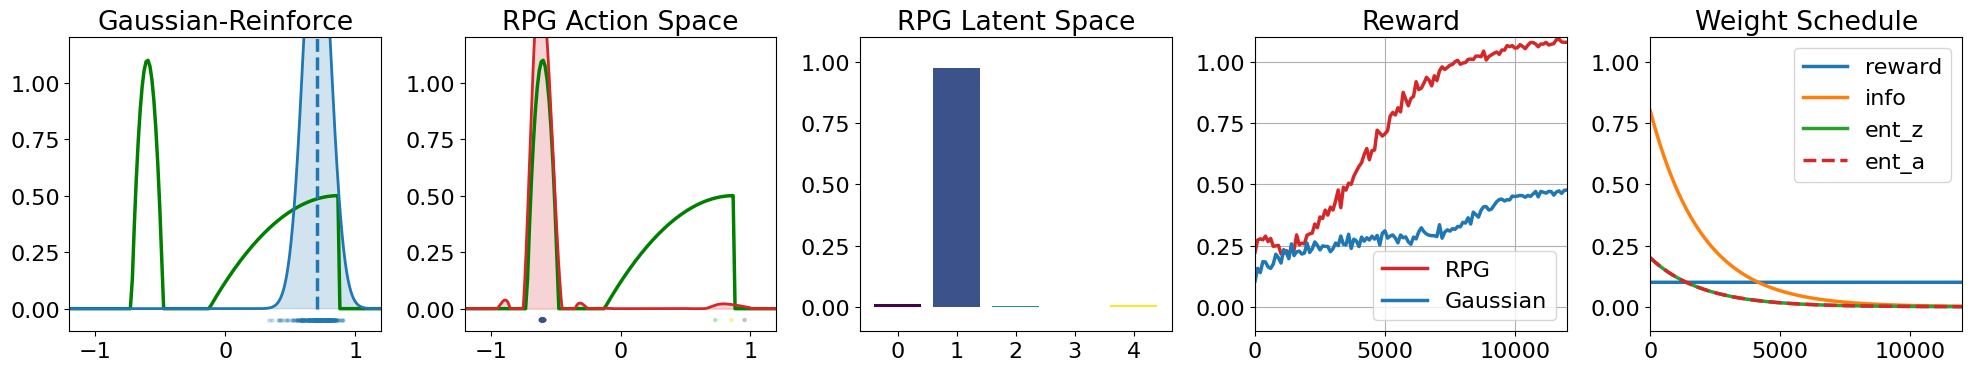

100%|██████████| 12001/12001 [01:55<00:00, 104.33it/s]


In [19]:
import tqdm

# learn a reparameterized policy
batch_size = 256
reward_weight, info_weight, ent_z, ent_a = 0.1, 0.8, 0.2, 0.2
z_dim = 5

# initialize RPG components and optimizer
pi_z = RPGLatentPolicy(z_dim=z_dim)
pi_a = RPGActionPolicy(z_dim=z_dim)
infonet = Info(z_dim=z_dim).to(device)
rpg_policy = RPGPolicy(pi_z, pi_a).to(device)
rpg_policy_opt = torch.optim.Adam([*pi_z.parameters(), *pi_a.parameters()], lr=3e-4)
rpg_info_opt = torch.optim.Adam(infonet.parameters(), lr=3e-4)

# to compare, learn a gaussian policy as well
gaussian_policy = GaussianPolicy().to(device)
gaussian_opt = torch.optim.Adam(gaussian_policy.parameters(), lr=1e-3)

# decay the cross entropy and action entropy weight in reward
decay_rate = 0.9995

# record the reward
rewards_rpg = []
rewards_gaussian = []
elbos = []
reward_weights, info_weights, ent_zs, ent_as = [], [], [], []
video_imgs = []

visualize_every = 100
T = 12000

for t in tqdm.trange(T + 1):
    
    # update rpg policy
    rpg_update_info = \
        update_rpg(
            reward, rpg_policy, rpg_policy_opt, rpg_info_opt, 
            reward_weight, info_weight, ent_z, ent_a, batch_size)
    
    # to compare, optimize gaussian policy with reinforce
    gaussian_update_info = \
        update_gaussian_reinforce(
            reward, gaussian_policy, gaussian_opt, 
            reward_weight, ent_a, batch_size)

    # decay the weights
    info_weight, ent_z, ent_a = info_weight * decay_rate, ent_z * decay_rate, ent_a * decay_rate
    
    # record
    reward_weights.append(reward_weight)
    info_weights.append(info_weight)
    ent_zs.append(ent_z)
    ent_as.append(ent_a)

    # visualize
    if t % visualize_every == 0:
        rewards_rpg.append(rpg_update_info["reward"])
        elbos.append(rpg_update_info["elbo"])
        rewards_gaussian.append(gaussian_update_info["reward"])

        clear_output(wait=True)
        total_plots = 5
        fig_width = 4
        plt.figure(figsize=(total_plots * fig_width, fig_width))

        # visualize Gaussian-Reinforce
        plt.subplot(1, total_plots, 1)
        plt.title("Gaussian-Reinforce")
        x = torch.linspace(-1.5, 1.5, 200)
        y = reward(x)
        plot_reward(x, y)
        visualize_gaussian_policy(gaussian_policy, batch_size=256)

        # visualize RPG
        plt.subplot(1, total_plots, 2)
        plt.ylim(-0.1, 1.1)
        plt.title(f"RPG Action Space")
        x = torch.linspace(-1.5, 1.5, 200)
        y = reward(x)
        plot_reward(x, y)
        visualize_rpg_policy(rpg_policy, batch_size=256, pdf_scale=0.5)

        # visualize latent space
        plt.subplot(1, total_plots, 3)
        plt.title("RPG Latent Space")
        plt.ylim(-0.1, 1.1)
        r = rpg_update_info["reward"]
        z, log_prob_z = rpg_update_info["z"], rpg_update_info["log_prob_z"]
        # r_z_ordered = (r * z).mean(0).detach().cpu().numpy().reshape(-1)
        pi_z_orderd = z.mean(0).detach().cpu().numpy().reshape(-1)
        z_space = np.arange(z_dim)
        # plt.bar(z_space, r_z_ordered, color="green")
        barplot_color(z_space, pi_z_orderd) # "C3"

        # visualize reward
        plt.subplot(1, total_plots, 4)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Reward")
        plt.plot(np.arange(len(rewards_rpg)) * visualize_every, rewards_rpg, color="C3", label="RPG")
        plt.plot(np.arange(len(rewards_gaussian)) * visualize_every, rewards_gaussian, color="C0", label="Gaussian")
        plt.grid()
        plt.legend(loc="lower right")

        # visualize weights
        plt.subplot(1, total_plots, 5)
        plt.xlim(0, T); plt.ylim(-0.1, 1.1)
        plt.title("Weight Schedule")
        plt.plot(reward_weights, label="reward")
        plt.plot(info_weights, label="info")
        plt.plot(ent_zs, label="ent_z")
        plt.plot(ent_as, linestyle="dashed", label="ent_a")
        plt.legend(loc="upper right")

        plt.tight_layout()
        video_imgs.append(plt_save_fig_array(close=False, clear=False))
        plt.show()

In [20]:
animate(video_imgs, filename="tiny_rpg.mp4", fps=10)
animate(video_imgs, filename="tiny_rpg.gif", fps=10)

animating tiny_rpg.mp4
Moviepy - Building video tiny_rpg.mp4.
Moviepy - Writing video tiny_rpg.mp4



Moviepy - Done !
Moviepy - video ready tiny_rpg.mp4
animating tiny_rpg.gif


HTML(value='<img src="tiny_rpg.gif" width="750" align="center">')